In [1]:
pip install transformers

In [2]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00


In [3]:
pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.0 MB/s eta 0:00:00


In [4]:
# install Hugging Face Libraries
!pip install "peft==0.2.0"
!pip install "transformers==4.27.2" "datasets==2.9.0" "accelerate==0.17.1" "evaluate==0.4.0" "bitsandbytes==0.37.1" loralib --upgrade --quiet
# install additional dependencies needed for training
!pip install rouge-score tensorboard py7zr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 709.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB

In [5]:
from typing import Optional, Union
import pandas as pd
import numpy as np
import random
import os
import gc
import torch
from datasets import Dataset
from dataclasses import dataclass
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoModel
from transformers import EarlyStoppingCallback, IntervalStrategy
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm
from string import Template
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

try:
    import peft
except:
    !pip install peft --no-index --find-links=/kaggle/input/llm-dl-training-libraries/peft
from peft import get_peft_config, get_peft_model, PeftModel, PeftConfig, LoraConfig, TaskType


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from datasets import load_dataset
data_path = '/content/drive/MyDrive/kaggle/kaggle-llm-science-exam/train.csv'
data_wiki = "/content/drive/MyDrive/kaggle/kaggle-llm-science-exam/6000_wiki_en_sci_questions.csv"
data_extra = "/content/drive/MyDrive/kaggle/kaggle-llm-science-exam/extra_df.csv"
data_stem = "/content/drive/MyDrive/kaggle/kaggle-llm-science-exam/stem_1k_full_v1.csv"
df_test = pd.read_csv(data_path).drop("id", axis = 1)
wiki = pd.read_csv(data_wiki)
df_extra= pd.read_csv(data_extra)
df_stem= pd.read_csv(data_stem)
df_stem = df_stem[["question"	,"option_1",	"option_2","option_3"	,"option_4"	,"option_5"	,"answer"]]
#df_stem["id"] = 0
df_stem.columns = df_test.columns
df_stem["answer"] = df_stem["answer"].replace("option_1", "A").replace("option_2", "B").replace("option_3", "C").replace("option_4", "D").replace("option_5", "E")

df_train = pd.concat([wiki, df_stem,df_extra], axis = 0).reset_index(drop = True).drop("id", axis = 1)
print(df_train.shape)
df_train.head()

(10251, 7)


,prompt,A,B,C,D,E,answer
0,What is needed for a fax demodulator to interc...,A fax demodulator requires direct physical con...,A fax demodulator requires a network connectio...,A fax demodulator requires access to a satelli...,A fax demodulator requires listening in on a t...,A fax demodulator requires a wireless connecti...,D
1,What is the process of dissimilar friction sti...,Welding of different base metals using a rotat...,Melting of different base metals using a frict...,Melting and stirring together of different bas...,Joining different base metals using a friction...,Softening of different base metals using a fri...,D
2,How can lacceroic acid be obtained as a crysta...,Lacceroic acid can be obtained by the action o...,Lacceroic acid can be obtained by oxidation of...,Lacceroic acid cannot be obtained as a crystal...,Lacceroic acid can be derived by saponificatio...,Lacceroic acid can be isolated from stick lac ...,A
3,What is High Blast Explosive (HBX) primarily u...,HBX is an explosive used in the construction o...,HBX is an explosive used in the mining industr...,HBX is an explosive used in fireworks and pyro...,HBX is an explosive used in the manufacturing ...,HBX is an explosive used in military applicati...,E
4,What is the function of the KCNG1 gene in humans?,Modulating epithelial electrolyte transport an...,Facilitating smooth muscle contraction and cel...,Regulating neurotransmitter release and heart ...,Controlling insulin secretion and neuronal exc...,"Encoding a member of the potassium channel, vo...",E


In [8]:
print(df_test.shape)
df_test.head()

(200, 7)


,prompt,A,B,C,D,E,answer
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [9]:
test_dataset = Dataset.from_pandas(df_test)
train_dataset = Dataset.from_pandas(df_train)
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
    num_rows: 10251
})
Dataset({
    features: ['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
    num_rows: 200
})


In [10]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = 'label' if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions

    def average_precision_at_k(actual, predicted, k):
        sorted_answer_indices = np.argsort(-predicted)
        top_answer_indices = sorted_answer_indices[:k]
        actual = int(actual)
        top_answer_indices = [int(i) for i in top_answer_indices]

        if actual in top_answer_indices:
            return [1,0.5,0.333333333333][top_answer_indices.index(actual)]
        else:
            return 0

    map_at_3_list = []
    for actual, predicted in zip(label_ids, predictions):
        ap_at_3 = average_precision_at_k(actual, predicted, k=3)
        map_at_3_list.append(ap_at_3)
    # Calculate the Mean Average Precision at 3 (MAP@3) using np.mean
    map_at_3 = np.mean(map_at_3_list)
    # Return a dictionary of metrics (including MAP@3)
    return {"MAP@3": map_at_3}

def getScore(trainer,df,token_ds):
    pred = trainer.predict(token_ds)

    map3_score = 0

    for index in tqdm(range(df.shape[0])):
        columns = df.iloc[index].values
        scores = -pred.predictions[index]
        predict = np.array(list("ABCDE"))[np.argsort(scores)][:3].tolist()
        if columns[6] in predict:
            map3_score += [1,0.5,0.333333333333][predict.index(columns[6])]
    map3_score /= df.shape[0]
    print(f'score = {map3_score}')

    return map3_score

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    first_sentence = [example['prompt']] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, padding=True, truncation=True)
    tokenized_example['label'] = option_to_index[example['answer']]

    return tokenized_example

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [11]:
models = ["distilbert-base-uncased", 'microsoft/deberta-v3-base']

target_modules = {"distilbert-base-uncased" : ["q_lin","k_lin","v_lin"],
                  'microsoft/deberta-v3-base' : ["query_proj","key_proj","value_proj"]}

print(target_modules['microsoft/deberta-v3-base'])

['query_proj', 'key_proj', 'value_proj']


In [12]:
history = pd.DataFrame()

for model in models:
  print(model)
  model_path = model

  tokenizer = AutoTokenizer.from_pretrained(model_path)


  #dataset = Dataset.from_pandas(df_train)
  tokenized_train_dataset = train_dataset.map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
  tokenized_test_dataset = test_dataset.map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

  mymodel = AutoModelForMultipleChoice.from_pretrained(model_path)
  peft_config = LoraConfig(task_type=TaskType.TOKEN_CLS,r=8,target_modules = target_modules[model_path],
                          lora_alpha=32,lora_dropout=0.1)
  mymodel = get_peft_model(mymodel,peft_config)



  print_trainable_parameters(mymodel)

  training_args = TrainingArguments(
      learning_rate=5e-5,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=10,
      report_to='none',
      output_dir=".",
      overwrite_output_dir=True,
      load_best_model_at_end=True,
      save_total_limit=1,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      metric_for_best_model = "MAP@3",
      greater_is_better = True

  )

  trainer = Trainer(
      model=mymodel,
      args=training_args,
      tokenizer=tokenizer,
      data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
      train_dataset=tokenized_train_dataset,
      eval_dataset=tokenized_test_dataset,
      compute_metrics=compute_metrics,
      callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
  )

  trainer.train()

  logs = pd.DataFrame(trainer.state.log_history).dropna(subset = ["eval_MAP@3"])
  logs["model"] = model
  history = pd.concat([history, logs], axis = 0)

  # Save our tokenizer and create model card
  repository_id = model + "-kaggle-llm-science-exam"
  repository_id = repository_id.replace("microsoft/", "")

  #tokenizer.save_pretrained(repository_id)
  trainer.model.push_to_hub(repository_id)
  tokenizer.push_to_hub(repository_id)



distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/10251 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ex/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultipleChoice: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN

trainable params: 812545 || all params: 67175425 || trainable%: 1.21


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Map@3
1,1.440600,1.383183,0.611667
2,1.380700,1.347093,0.634167
3,1.369200,1.330263,0.635833
4,1.339900,1.315130,0.645833


Epoch,Training Loss,Validation Loss,Map@3
1,1.440600,1.383183,0.611667
2,1.380700,1.347093,0.634167
3,1.369200,1.330263,0.635833
4,1.339900,1.315130,0.645833
5,1.325000,1.303468,0.643333
6,1.327700,1.299825,0.640000
7,1.315700,1.300164,0.633333


adapter_model.bin:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/10251 [00:00<?, ?ex/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/200 [00:00<?, ?ex/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForMultipleChoice: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifi

trainable params: 443137 || all params: 184865281 || trainable%: 0.24


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Map@3
1,1.467300,1.229466,0.724167
2,1.280900,1.101126,0.738333
3,1.259000,1.063555,0.746667
4,1.224700,1.046027,0.740833
5,1.201800,1.033334,0.744167
6,1.190000,1.026745,0.750833
7,1.173500,1.024153,0.742500
8,1.174900,1.017471,0.745833
9,1.146400,1.013515,0.749167


adapter_model.bin:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

<Axes: xlabel='epoch', ylabel='eval_MAP@3'>

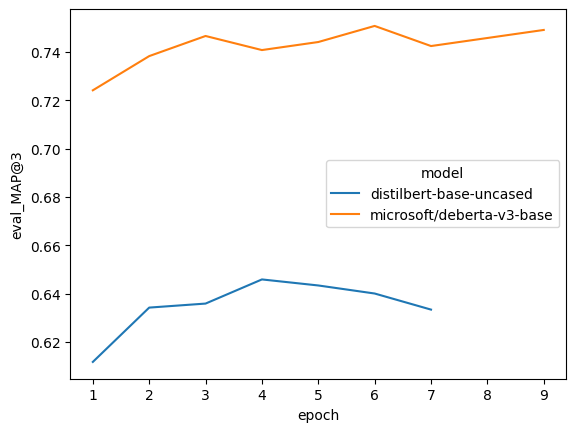

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=history, x="epoch", y="eval_MAP@3", hue="model"
)

In [14]:


# Load peft config for pre-trained checkpoint etc.
peft_model_id = "xavierbarbier/deberta-v3-base-kaggle-llm-science-exam"
config = PeftConfig.from_pretrained(peft_model_id)

# load base LLM model and tokenizer
model = AutoModelForMultipleChoice.from_pretrained(config.base_model_name_or_path,  load_in_8bit=True,  device_map={"":0})
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id, device_map={"":0})
model.eval()

print("Peft model loaded")

adapter_config.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForMultipleChoice: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining 

adapter_model.bin:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Peft model loaded


In [15]:
# Make predictions

from random import randint

i = randint(0, len(df_test))

first_sentence = [df_test['prompt'][i]] * 5
second_sentences = [df_test[option][i] for option in 'ABCDE']

encoding = tokenizer(first_sentence,second_sentences, return_tensors="pt", padding=True)
outputs = model(**{k: v.unsqueeze(0) for k, v in encoding.items()})

sorted_answer_indices = np.argsort(-outputs["logits"].detach().numpy())
answers = [list("ABCDE")[option] for option in sorted_answer_indices[0][:3]]

answers = ' '.join(answers)

print("Top 3 answers: ", answers)
df_test['answer'][i]

Top 3 answers:  E C B


'B'